In [1]:
import pandas as pd
import numpy as np
import nibabel as nib
from nilearn import plotting
import nilearn.plotting as plotting
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# --- Path to input / output data ---

""" Define hrf model used for the first analysis
    ---------
    Options : spm, glover, rat_hrf_gamma_diff, rat_hrf_delay_disp
"""

#hrf_function = 'glover'
#hrf_function = 'spm'
#hrf_function = 'rat_hrf_gamma_diff'
hrf_function = 'rat_hrf_delay_disp'
print('chosent HRF:', hrf_function)


if hrf_function == 'glover':
    first_level_input = '/project/4180000.19/multirat_stim/scratch/rabies_test/first_level/glover/'
    second_level_input = '/project/4180000.19/multirat_stim/scratch/rabies_test/second_level/glover/'
    output_dir = '/project/4180000.19/multirat_stim/scratch/plots/beta/glover_betas.svg'
elif hrf_function == 'spm':
    first_level_input = '/project/4180000.19/multirat_stim/scratch/rabies_test/first_level/spm/'
    second_level_input = '/project/4180000.19/multirat_stim/scratch/rabies_test/second_level/spm/'
    output_dir = '/project/4180000.19/multirat_stim/scratch/plots/beta/spm_betas.svg'
elif hrf_function == 'rat_hrf_gamma_diff':
    first_level_input = '/project/4180000.19/multirat_stim/scratch/rabies_test/first_level/rat_hrf_gamma_diff/'
    second_level_input = '/project/4180000.19/multirat_stim/scratch/rabies_test/second_level/rat_hrf_gamma_diff/'
    output_dir = '/project/4180000.19/multirat_stim/scratch/plots/beta/gamma_beta.svg'
elif hrf_function == 'rat_hrf_delay_disp':
    first_level_input = '/project/4180000.19/multirat_stim/scratch/rabies_test/first_level/rat_hrf_delay_disp/'
    second_level_input = '/project/4180000.19/multirat_stim/scratch/rabies_test/second_level/rat_hrf_delay_disp/'
    output_dir = '/project/4180000.19/multirat_stim/scratch/plots/beta/dd_betas.svg'
    
else:
    print('No file to be saved. Check that hrf_function is well defined.')
    
print('Path to first level: ', first_level_input)
print('Path to second level: ', second_level_input)


# Subject info 
metadata_stand ='/home/traaffneu/margal/code/multirat_se/script/table/metadata_stand.tsv'
df = pd.read_csv(metadata_stand, sep='\t')
df = df.loc[(df['exclude'] != 'yes')]

mean_betas_df = pd.DataFrame(columns=['Subject', 'Beta_Mean'])


chosent HRF: rat_hrf_delay_disp
Path to first level:  /project/4180000.19/multirat_stim/scratch/rabies_test/first_level/rat_hrf_delay_disp/
Path to second level:  /project/4180000.19/multirat_stim/scratch/rabies_test/second_level/rat_hrf_delay_disp/


In [3]:
dfs = []  # Empty list to store individual DataFrames

for subj in range(0, len(df)):       
    subj_num = str(df.iloc[subj]['rat.sub'])[:-2]   
    stim_location = df.iloc[subj]['func.sensory.system']  # Extract the stimulation location
    
    beta_csv = pd.read_csv(first_level_input + 'mask_ROIs/effect_size/effect_size_sub-0{}_ses-1.csv'.format(subj_num), header=None)
    beta_np = beta_csv.to_numpy()
    beta_stand = ((beta_np - np.mean(beta_np)) / np.std(beta_np))
    beta_mean = beta_stand.mean(axis=1)    

    dfs.append(pd.DataFrame({'Subject': [subj_num], 'Beta_Mean': [beta_mean[0]], 'Stim_Location': [stim_location]}))  # Append each DataFrame to the list

mean_betas_df = pd.concat(dfs, ignore_index=True)  # Concatenate the list of DataFrames into a single DataFrame

# Sort the DataFrames
mean_betas_df['Dataset'] = mean_betas_df['Subject'].str[2:4].astype(int)                     # Extract the dataset and store it in Dataset
mean_betas_df = mean_betas_df.sort_values(by=['Stim_Location', 'Dataset'])                   # Order the DataFrame by 'Stim_Location' and 'Dataset'ArithmeticError
eye_category_index = mean_betas_df[mean_betas_df['Stim_Location'] == 'eye'].index                       # Reorder -> 'eye' category appears last
mean_betas_df = mean_betas_df.drop(eye_category_index).append(mean_betas_df.loc[eye_category_index])

mean_betas_df.to_csv('/project/4180000.19/multirat_stim/scratch/plots/beta/{}_mean_betas_df.csv'.format(hrf_function), index=False)

print(mean_betas_df)


    Subject     Beta_Mean Stim_Location  Dataset
0    200100  1.441101e-16       forepaw        1
1    200101 -9.607338e-17       forepaw        1
2    200102  9.607338e-17       forepaw        1
3    200103 -1.521162e-16       forepaw        1
4    200104  1.601223e-17       forepaw        1
..      ...           ...           ...      ...
164  201708  9.731312e-17           eye       17
165  201709 -8.475659e-17           eye       17
166  201710  4.708699e-18           eye       17
167  201711 -8.161746e-17           eye       17
168  201712 -9.731312e-17           eye       17

[186 rows x 4 columns]


<ipython-input-3-63a88becbd72>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mean_betas_df = mean_betas_df.drop(eye_category_index).append(mean_betas_df.loc[eye_category_index])


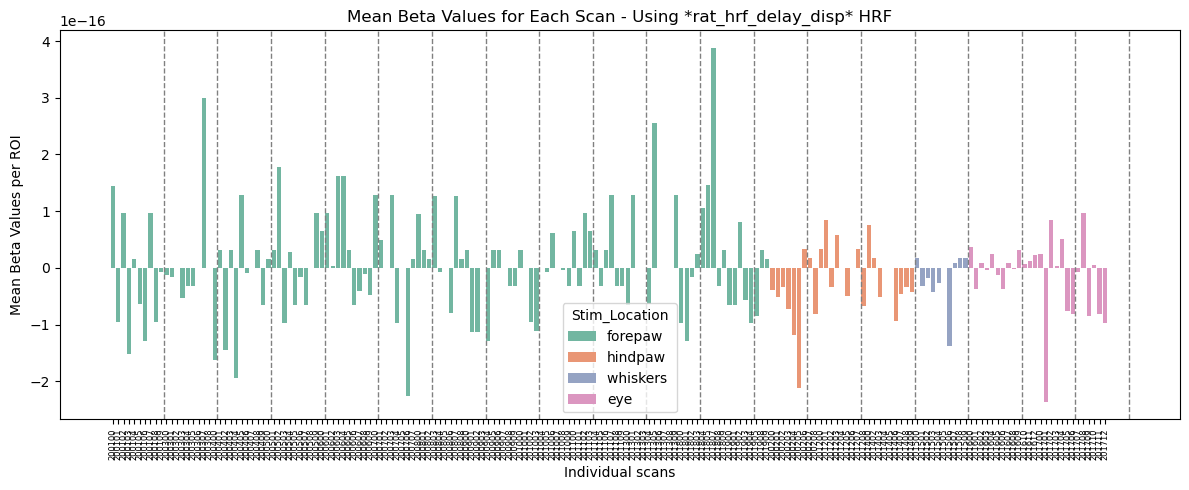

In [14]:

# Create the seaborn bar plot
dataset_palette = sns.color_palette("Set2", len(mean_betas_df['Dataset'].unique()))

plt.figure(figsize=(12, 5))
sns.barplot(data=mean_betas_df, x='Subject', y='Beta_Mean', hue='Stim_Location', dodge=False, palette=dataset_palette)
plt.xlabel('Individual scans')
plt.ylabel('Mean Beta Values per ROI')
plt.title('Mean Beta Values for Each Scan - Using *{}* HRF'.format(hrf_function))
plt.xticks(rotation=90, fontsize=6)

# Calculate the x-axis positions and add vertical lines to differentiate the 10 scans from each other
dataset_numbers = sorted(mean_betas_df['Dataset'].unique())
x_positions = [i * 10 - 0.5 for i in range(1, len(dataset_numbers) + 1)]
for pos in x_positions:                                                                 
    plt.axvline(x=pos, color='gray', linewidth=1, linestyle='--')


# Show the plot
plt.tight_layout()
#plt.savefig(output_dir, format='svg', dpi=100)
plt.show()
